In [11]:
# 绘制地震活动性分布图
import pygmt 
import numpy as np
import xarray as xr
from obspy import geodetics
import warnings
warnings.filterwarnings("ignore")
import glob
import os

In [12]:
def resolution(ds_vel,radius_km=5):
    vel_mod = ds_vel.vp_0
    vel_chk = ds_vel.vp_true
    vel     = ds_vel.vp
    vt_p,vr_p = vel_chk-vel_mod,vel-vel_mod
    
    vel_mod = ds_vel.vs_0
    vel_chk = ds_vel.vs_true
    vel     = ds_vel.vs
    vt_s,vr_s = vel_chk-vel_mod,vel-vel_mod
    
    nz,ny,nx = vel.shape
    x_coords = ds_vel.coords['longitude'].values
    y_coords = ds_vel.coords['latitude'].values
    z_coords = ds_vel.coords['depth'].values
    
    res_p = np.zeros([nz,ny,nx])
    res_s = np.zeros([nz,ny,nx])
    for k in range(nz):
        print('k=',k)
        for j in range(ny):
            for i in range(nx):
                x_ref = x_coords[i]
                y_ref = y_coords[j]
                z_ref = z_coords[k]
                # 计算直角坐标中的距离
                distances = np.sqrt((x_coords[None,:] - x_ref)**2 + 
                                    (y_coords[:,None] - y_ref)**2)
                # 根据半径选择点
                distances = geodetics.degrees2kilometers(distances)
                mask = distances <= radius_km
                
                vt_k  = vt_p.isel(depth=k).data[mask]
                vr_k  = vr_p.isel(depth=k).data[mask]
                mol = np.sum((vt_k + vr_k)**2)
                den = 2*np.sum((vt_k)**2 + (vr_k)**2)
                res_p[k,j,i] = mol/den
                
                vt_k  = vt_s.isel(depth=k).data[mask]
                vr_k  = vr_s.isel(depth=k).data[mask]
                mol = np.sum((vt_k + vr_k)**2)
                den = 2*np.sum((vt_k)**2 + (vr_k)**2)
                res_s[k,j,i] = mol/den
    res_p = xr.DataArray(res_p,dims=ds_vel.dims, coords=ds_vel.coords,name = 'res_p')
    res_s = xr.DataArray(res_s,dims=ds_vel.dims, coords=ds_vel.coords,name = 'res_s')
    ds_vel['res_p'] = res_p
    ds_vel['res_s'] = res_s
    return ds_vel

In [13]:
# 绘制两个不同模型的速度结构
model1 = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_velocity_1_19.h5')
model2 = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_velocity_2_19.h5')
model3 = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_velocity_3_19.h5')
chk1   = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_checkerboard_1_19.h5')
chk2   = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_checkerboard_2_19.h5')
chk3   = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_checkerboard_3_19.h5')

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0119665; the original ranges from 0.0104707 to 0.0209414.
grdinfo [WARNING]: The step size of coordinate (latitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0102576; the original ranges from 0.00901961 to 0.0180392.
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_checkerboard_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0119665; the original ranges from 0.0104707 to 0.0209414.
grdinfo [WARNING]: The st

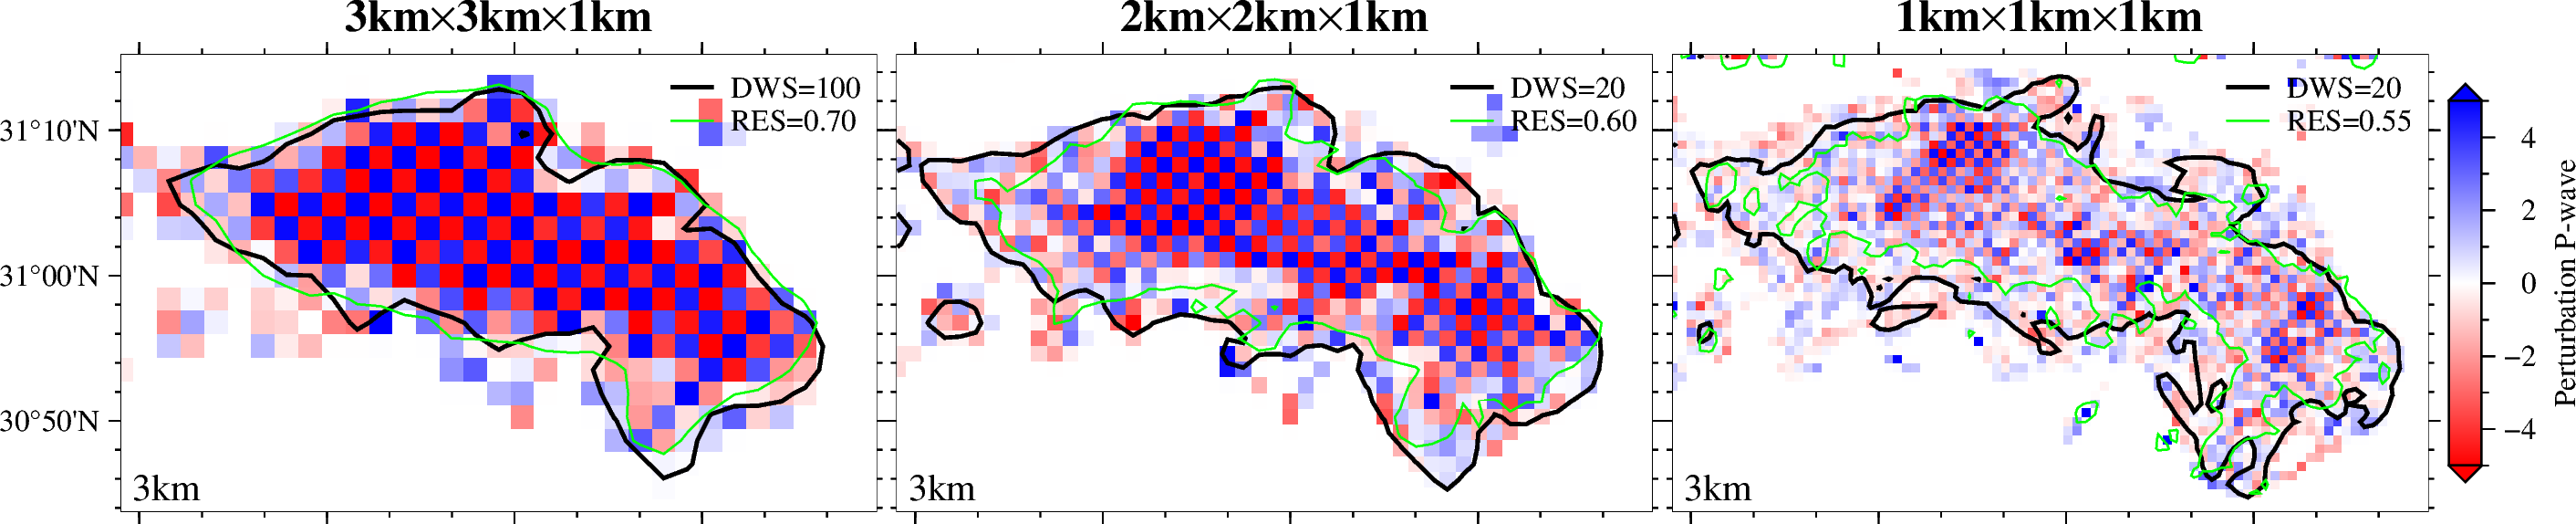

In [14]:
depth = 3
grid1,grid2,grid3 = model1.vp.sel(depth=depth),model2.vp.sel(depth=depth),model3.vp.sel(depth=depth)
grid_dwsp1,grid_dwsp2,grid_dwsp3 = model1.dwsp.sel(depth=depth),model2.dwsp.sel(depth=depth), model3.dwsp.sel(depth=depth)
grid_resp1,grid_resp2,grid_resp3 = chk1.res_p.sel(depth=depth),chk2.res_p.sel(depth=depth),chk3.res_p.sel(depth=depth)
grid_chk_vp1,grid_chk_vp2,grid_chk_vp3 = chk1.vp_perc.sel(depth=depth),chk2.vp_perc.sel(depth=depth),chk3.vp_perc.sel(depth=depth)
lons,lats = grid1.longitude.values,grid1.latitude.values
region = [lons[0],lons[-1],lats[0],lats[-1]]

fig = pygmt.Figure()
pygmt.config(FONT='8p,4',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p',MAP_TITLE_OFFSET='-5p',FONT_TITLE='12p,5')
pygmt.makecpt(cmap='seis',series=[4.5,7.5,0.1],continuous=True,background=True,output='velp.cpt')
pygmt.makecpt(cmap='polar',series=[-5,5,0.1],continuous=True,background=True,reverse=True,output='chk.cpt')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','Wsen+t3km@~\\264@~3km@~\\264@~1km'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)

fig.grdimage(grid=grid_chk_vp3*100,cmap='chk.cpt')
fig.grdcontour(grid=grid_dwsp3,interval=100,limit=[100,100],pen='1.0p,black',label='DWS=100')
fig.grdcontour(grid=grid_resp3,interval=0.7,limit=[0.7,0.7],pen='0.5p,green',label='RES=0.70')
fig.text(position='cBL',text=f'{depth}km',font='10p',offset='0.1c/0.1c',fill='white')
fig.legend(position='jTR')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen+t2km@~\\264@~2km@~\\264@~1km'])
fig.grdimage(grid=grid_chk_vp2*100,cmap='chk.cpt')
fig.grdcontour(grid=grid_dwsp2,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.grdcontour(grid=grid_resp2,interval=0.6,limit=[0.6,0.6],pen='0.5p,green',label='RES=0.60')
fig.text(position='cBL',text=f'{depth}km',font='10p',offset='0.1c/0.1c',fill='white')
fig.legend(position='jTR')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen+t1km@~\\264@~1km@~\\264@~1km'])
fig.grdimage(grid=grid_chk_vp1*100,cmap='chk.cpt')
fig.grdcontour(grid=grid_dwsp1,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.grdcontour(grid=grid_resp1,interval=0.55,limit=[0.55,0.55],pen='0.5p,green',label='RES=0.55')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xaf+lPerturbation P-wave'],cmap='chk.cpt')
fig.text(position='cBL',text=f'{depth}km',font='10p',offset='0.1c/0.1c',fill='white')
fig.legend(position='jTR')

fig.show()

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0119665; the original ranges from 0.0104707 to 0.0209414.
grdinfo [WARNING]: The step size of coordinate (latitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0102576; the original ranges from 0.00901961 to 0.0180392.
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0

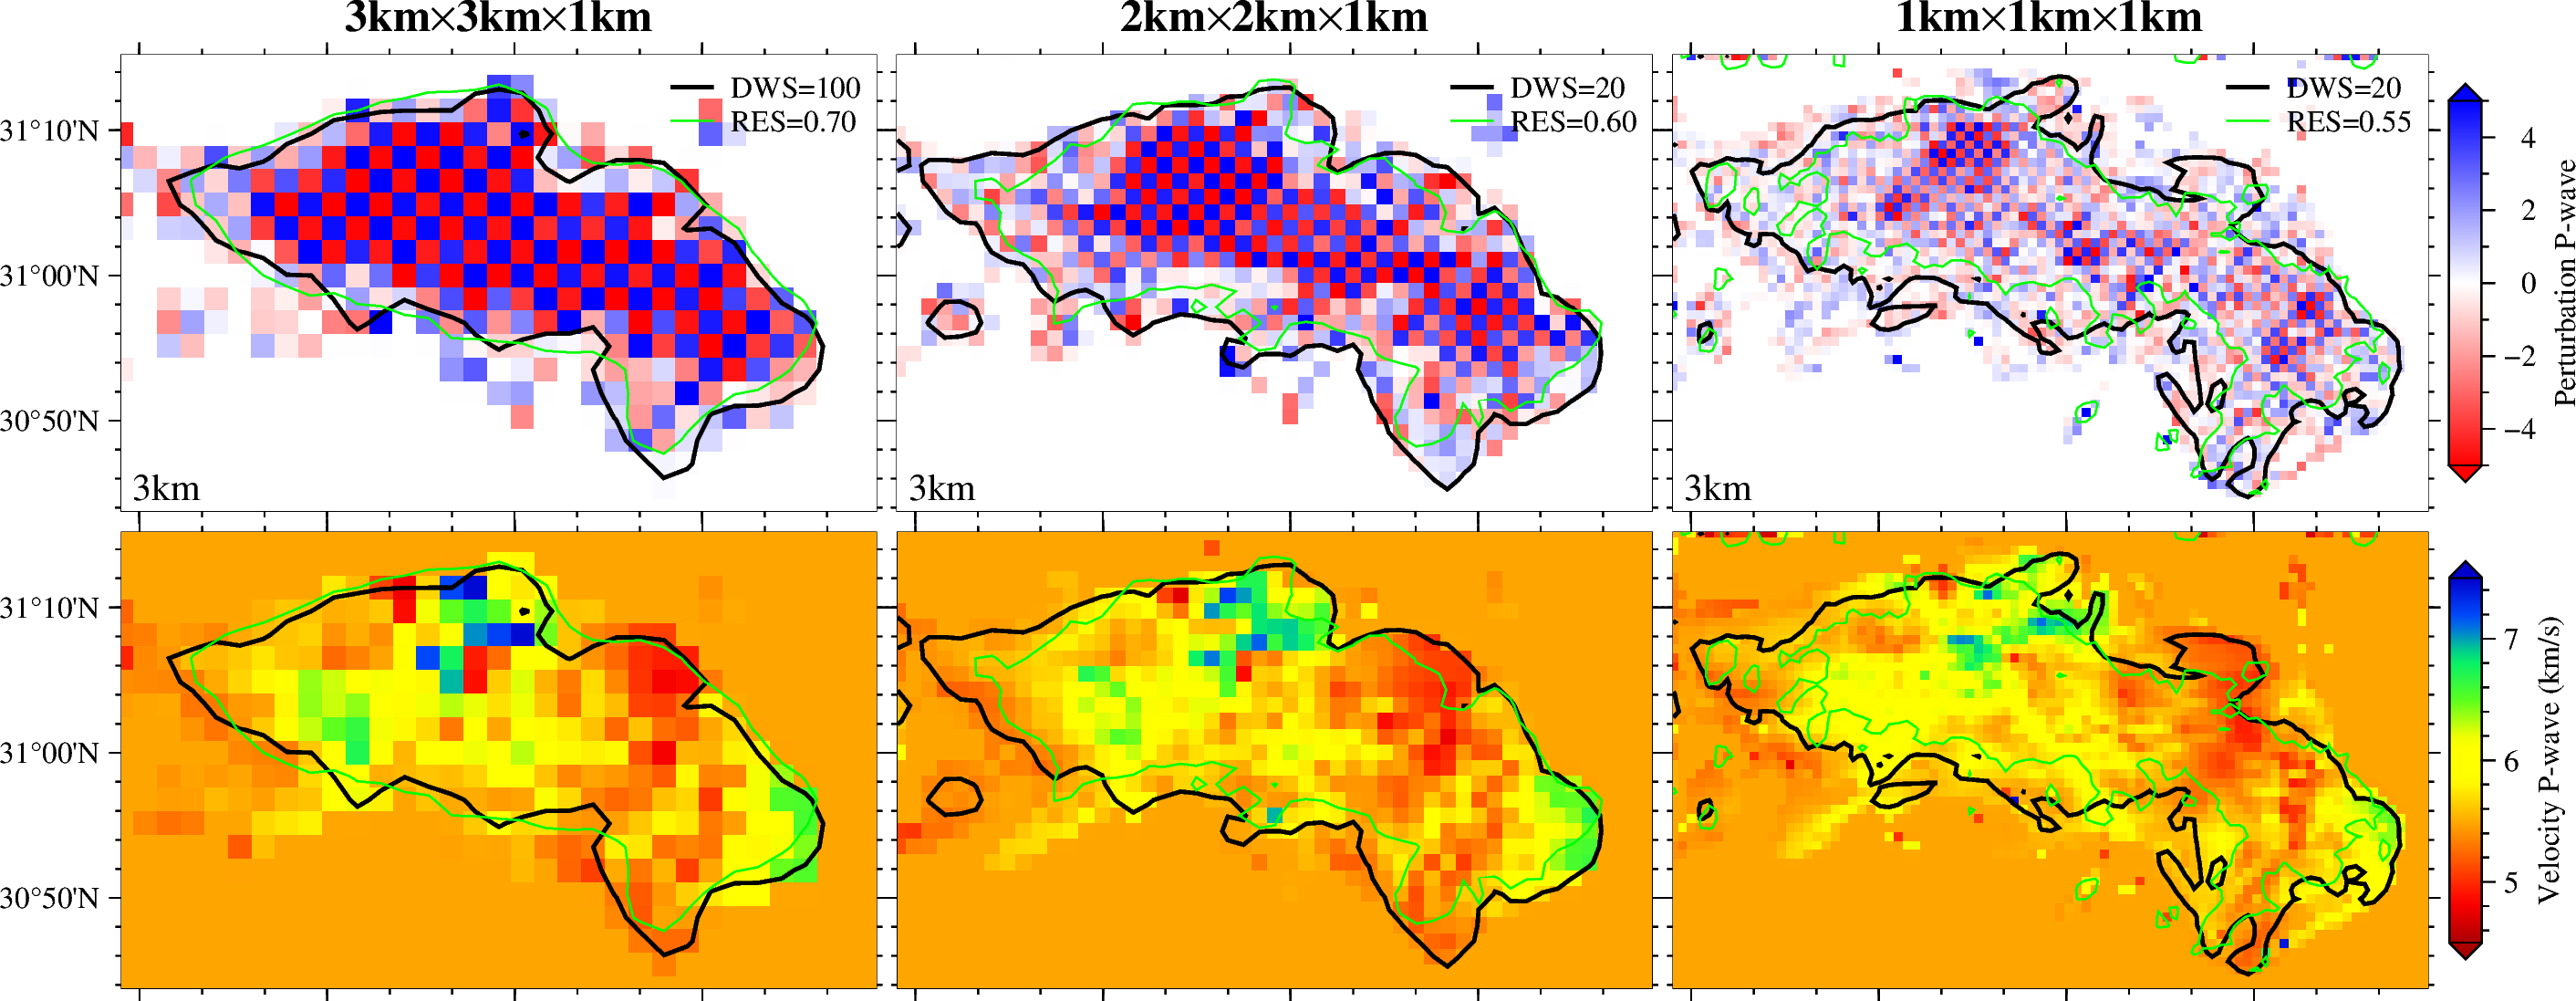

In [15]:
grid1,grid2,grid3 = model1.vp.sel(depth=depth),model2.vp.sel(depth=depth),model3.vp.sel(depth=depth)
grid_dwsp1,grid_dwsp2,grid_dwsp3 = model1.dwsp.sel(depth=depth),model2.dwsp.sel(depth=depth), model3.dwsp.sel(depth=depth)
grid_resp1,grid_resp2,grid_resp3 = chk1.res_p.sel(depth=depth),chk2.res_p.sel(depth=depth),chk3.res_p.sel(depth=depth)
grid_chk_vp1,grid_chk_vp2,grid_chk_vp3 = chk1.vp_perc.sel(depth=depth),chk2.vp_perc.sel(depth=depth),chk3.vp_perc.sel(depth=depth)

pygmt.makecpt(cmap='seis',series=[4.5,7.5,0.1],continuous=True,background=True,output='velp.cpt')
fig.shift_origin(xshift='-{}c'.format(7.2*2),yshift='-{}c'.format(map_height+0.2))
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','Wsen'])

fig.grdimage(grid=grid3,cmap='velp.cpt')
fig.grdcontour(grid=grid_dwsp3,interval=100,limit=[100,100],pen='1.0p,black',label='DWS=100')
fig.grdcontour(grid=grid_resp3,interval=0.7,limit=[0.7,0.7],pen='0.5p,green',label='RES=0.70')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen'])
fig.grdimage(grid=grid2,cmap='velp.cpt')
fig.grdcontour(grid=grid_dwsp2,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.grdcontour(grid=grid_resp2,interval=0.6,limit=[0.6,0.6],pen='0.5p,green',label='RES=0.60')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen'])
fig.grdimage(grid=grid1,cmap='velp.cpt')
fig.grdcontour(grid=grid_dwsp1,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.grdcontour(grid=grid_resp1,interval=0.55,limit=[0.55,0.55],pen='0.5p,green',label='RES=0.55')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xaf+lVelocity P-wave (km/s)'],cmap='velp.cpt')

fig.show()

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0119665; the original ranges from 0.0104707 to 0.0209414.
grdinfo [WARNING]: The step size of coordinate (latitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0102576; the original ranges from 0.00901961 to 0.0180392.
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0

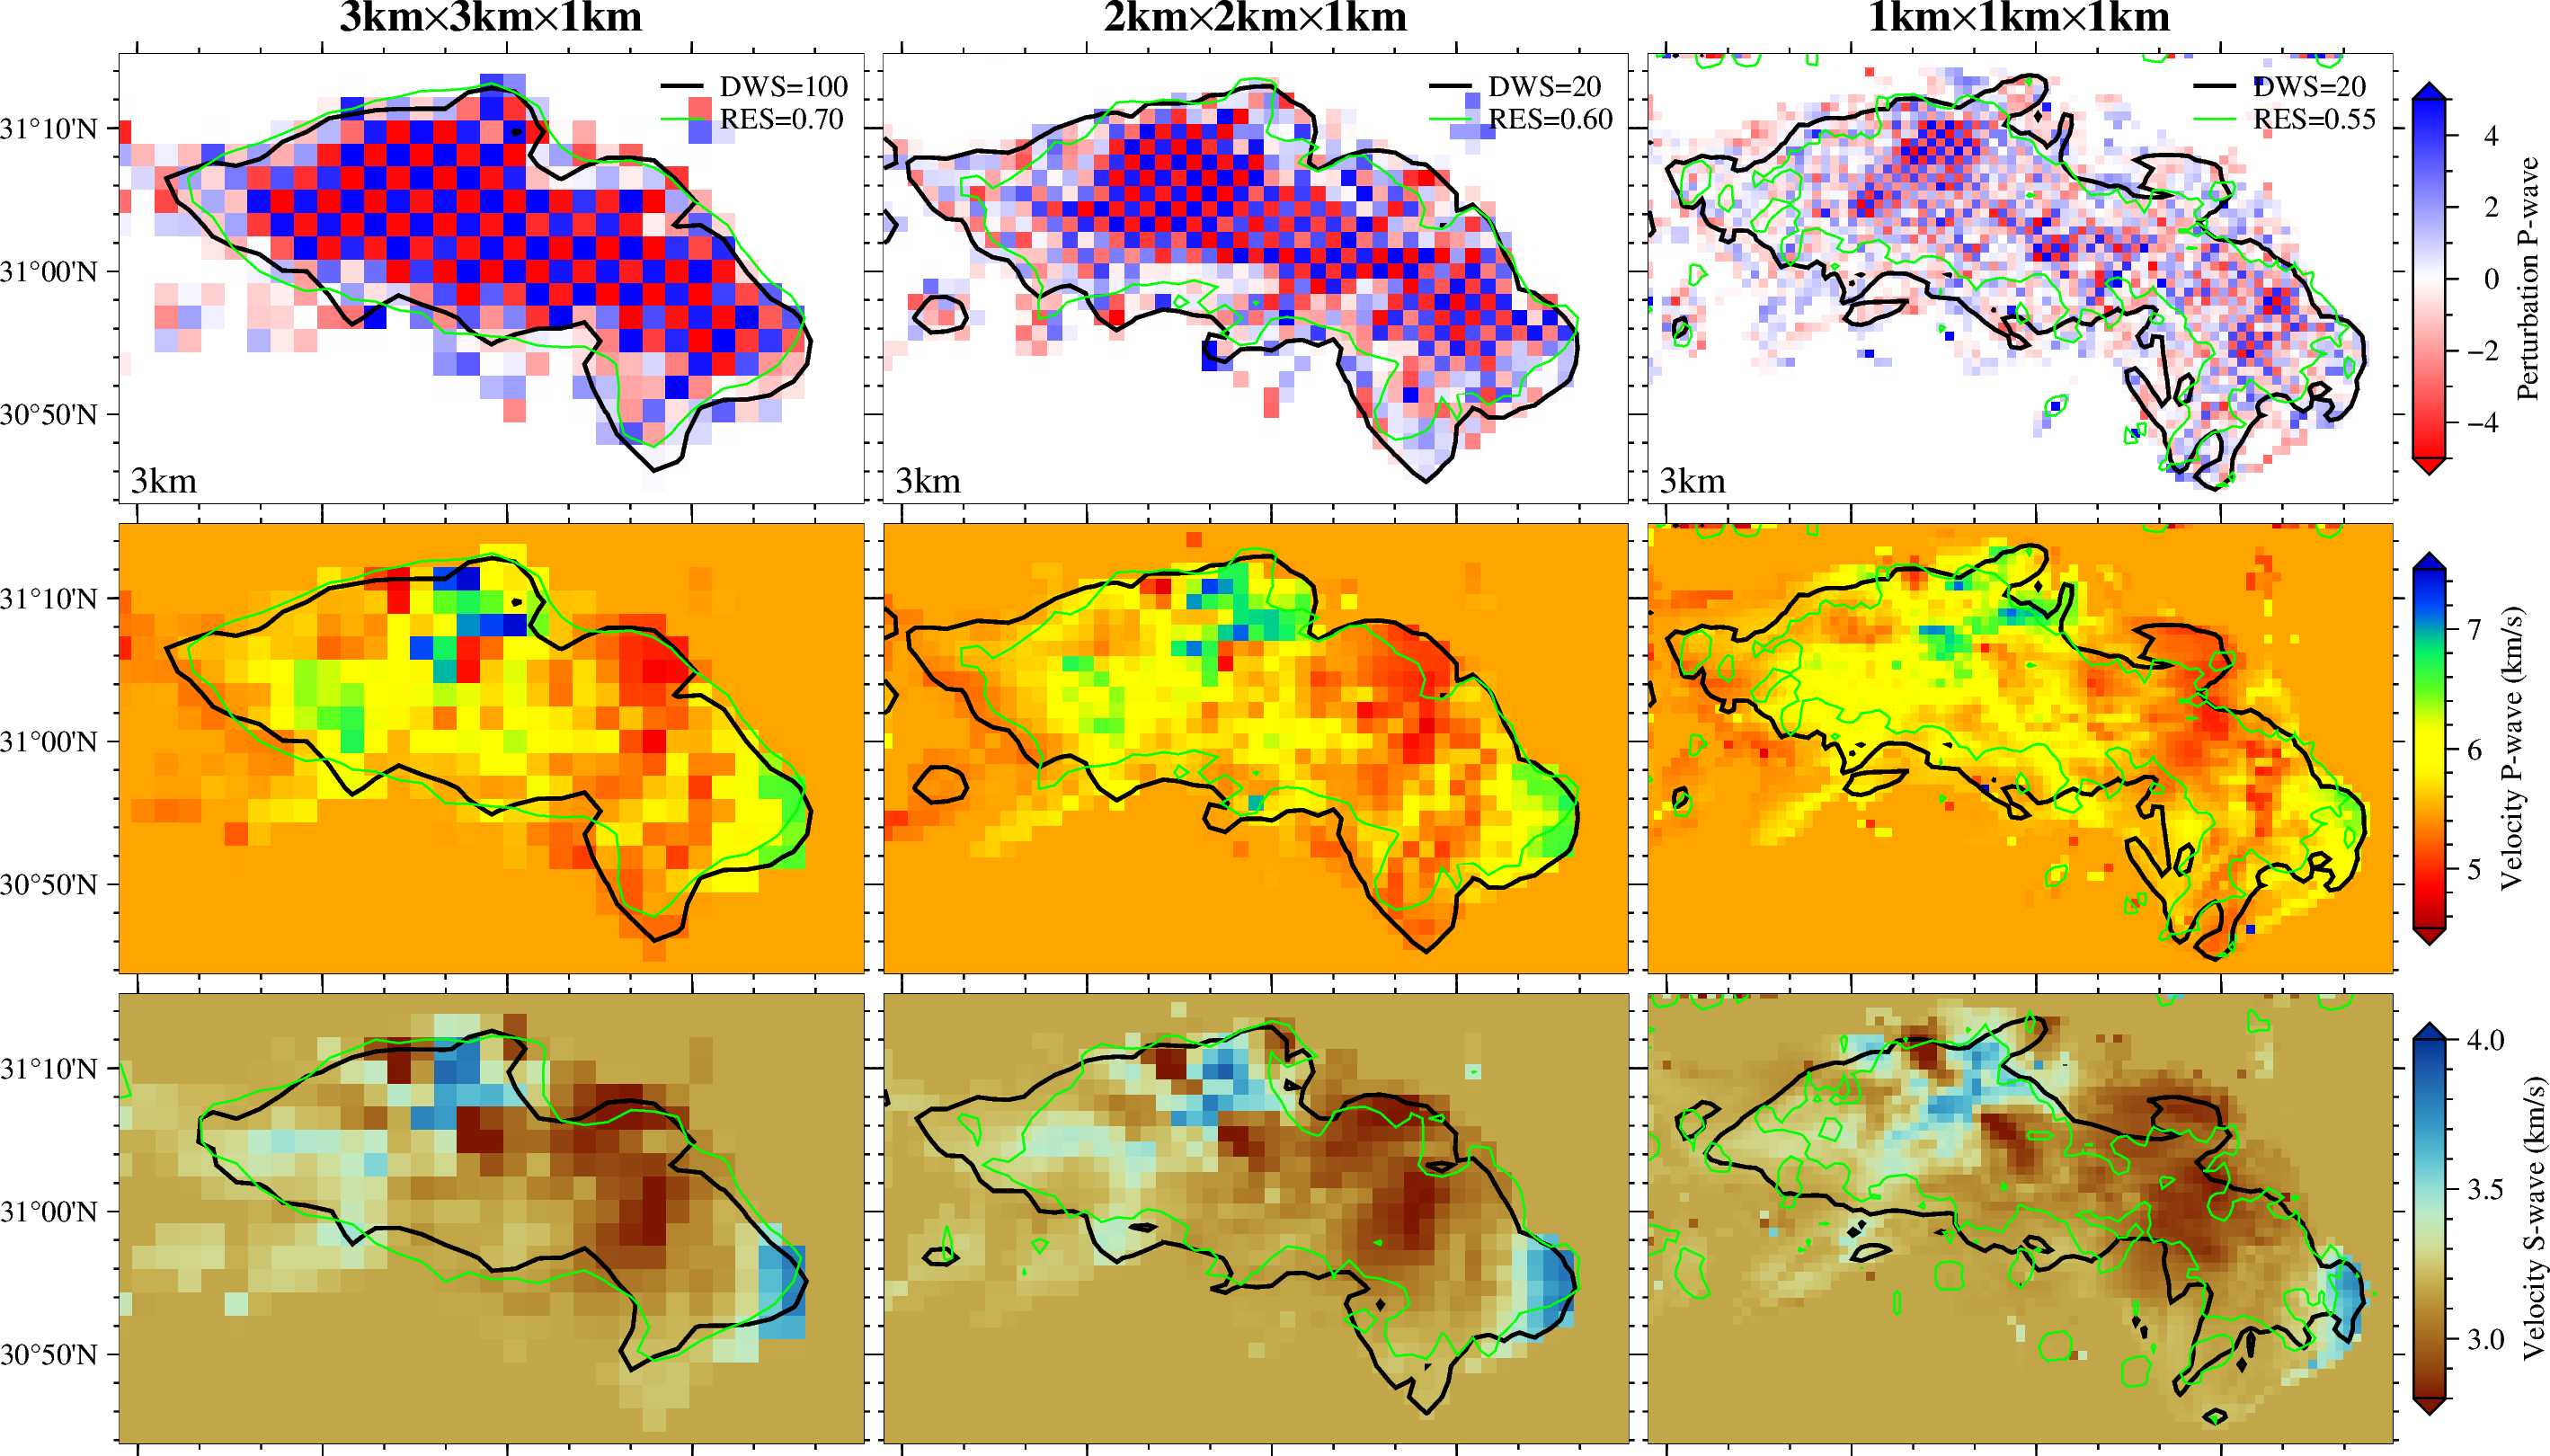

In [16]:
grid1,grid2,grid3 = model1.vs.sel(depth=depth),model2.vs.sel(depth=depth),model3.vs.sel(depth=depth)
grid_dwsp1,grid_dwsp2,grid_dwsp3 = model1.dwss.sel(depth=depth),model2.dwss.sel(depth=depth),model3.dwss.sel(depth=depth)
grid_resp1,grid_resp2,grid_resp3 = chk1.res_s.sel(depth=depth),chk2.res_s.sel(depth=depth),chk3.res_s.sel(depth=depth)

fig.shift_origin(xshift='-{}c'.format(7.2*2),yshift='-{}c'.format(map_height+0.2))
pygmt.makecpt(cmap='roma',series=[2.8,4.0,0.1],continuous=True,background=True,output='vels.cpt')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','Wsen'])
fig.grdimage(grid=grid3,cmap='vels.cpt')
fig.grdcontour(grid=grid_dwsp3,interval=100,limit=[100,100],pen='1.0p,black',label='DWS=100')
fig.grdcontour(grid=grid_resp3,interval=0.7,limit=[0.7,0.7],pen='0.5p,green',label='RES=0.70')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen'])
fig.grdimage(grid=grid2,cmap='vels.cpt')
fig.grdcontour(grid=grid_dwsp2,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.grdcontour(grid=grid_resp2,interval=0.6,limit=[0.6,0.6],pen='0.5p,green',label='RES=0.60')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen'])
fig.grdimage(grid=grid1,cmap='vels.cpt')
fig.grdcontour(grid=grid_dwsp1,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.grdcontour(grid=grid_resp1,interval=0.55,limit=[0.55,0.55],pen='0.5p,green',label='RES=0.55')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xaf+lVelocity S-wave (km/s)'],cmap='vels.cpt')
fig.show()

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0119665; the original ranges from 0.0104707 to 0.0209414.
grdinfo [WARNING]: The step size of coordinate (latitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0102576; the original ranges from 0.00901961 to 0.0180392.
grdinfo [WARNING]: The step size of coordinate (longitude) in grid d:\GitHub\tomoDD_TGR\TGR_data\tomoDD09\TGR_2009_velocity_1_19.h5 is not constant.
grdinfo [WARNING]: GMT will use a constant step size of 0.0119665; the original ranges from 0.0104707 to 0.0209414.
grdinfo [WARNING]: The step s

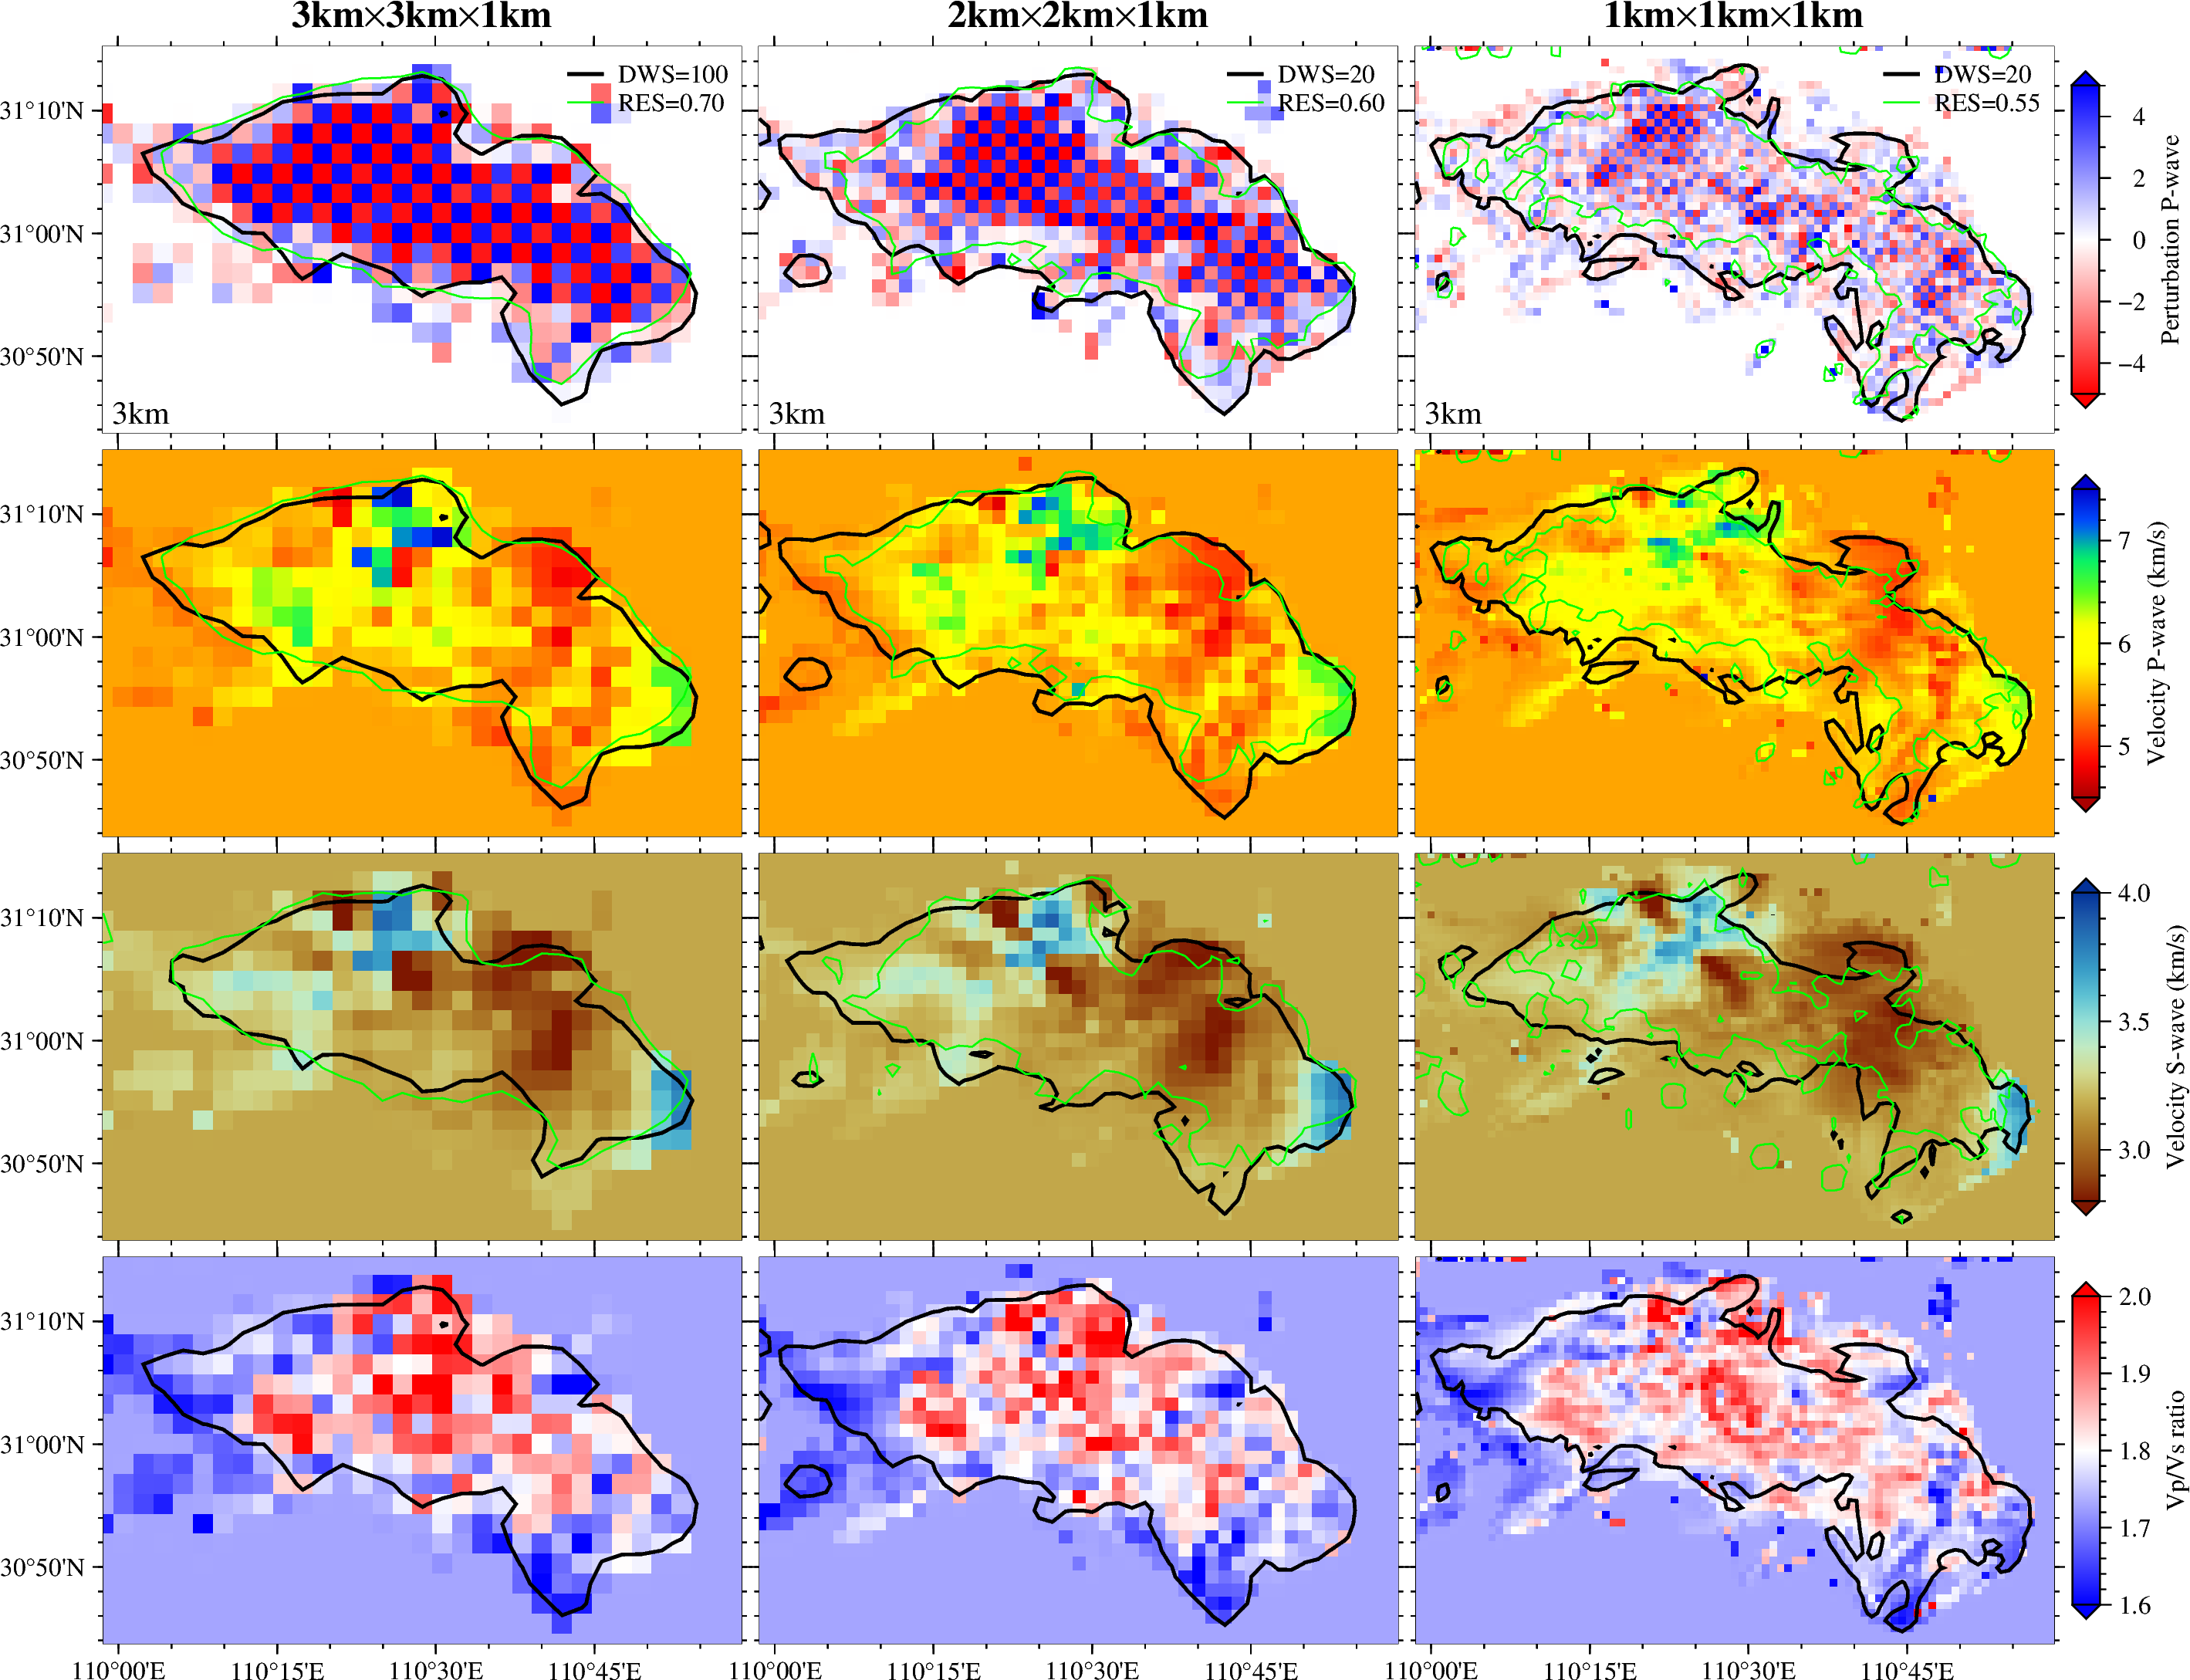

In [17]:
grid1,grid2,grid3 = model1.vpvs.sel(depth=depth),model2.vpvs.sel(depth=depth),model3.vpvs.sel(depth=depth)
grid_dwsp1,grid_dwsp2,grid_dwsp3 = model1.dwsp.sel(depth=depth),model2.dwsp.sel(depth=depth),model3.dwsp.sel(depth=depth)
grid_resp1,grid_resp2,grid_resp3 = chk1.res_p.sel(depth=depth),chk2.res_p.sel(depth=depth),chk3.res_p.sel(depth=depth)
grid_ress1,grid_ress2,grid_ress3 = chk1.res_s.sel(depth=depth),chk2.res_s.sel(depth=depth),chk3.res_s.sel(depth=depth)

fig.shift_origin(xshift='-{}c'.format(7.2*2),yshift='-{}c'.format(map_height+0.2))
pygmt.makecpt(cmap='polar',series=[1.6,2.0,0.1],reverse=False,continuous=True,background=True,output='vpvs.cpt')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','WSen'])
fig.grdimage(grid=grid3,cmap='vpvs.cpt')
fig.grdcontour(grid=grid_dwsp3,interval=100,limit=[100,100],pen='1.0p,black',label='DWS=100')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wSen'])
fig.grdimage(grid=grid2,cmap='vpvs.cpt')
fig.grdcontour(grid=grid_dwsp2,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xaf+lVelocity P-wave (km/s)'])

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wSen'])
fig.grdimage(grid=grid1,cmap='vpvs.cpt')
fig.grdcontour(grid=grid_dwsp1,interval=20,limit=[20,20],pen='1.0p,black',label='DWS=20')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xaf+lVp/Vs ratio'],cmap='vpvs.cpt')
fig.show()

In [18]:
fig.savefig(f'plotting_figures/FigureS8_compare_velocity.png',dpi=600)
fig.savefig(f'plotting_figures/FigureS8_compare_velocity.pdf')

In [19]:
for file in glob.glob('*.cpt'):
    os.remove(file)